<a href="https://colab.research.google.com/github/Lanssser/inf1340-programmingfordatascience-fa22/blob/main/final-project-submissions/mingli_wang_FinalProject/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Final Project

##Preparation

In [39]:
#=====Step 0=====
#Import libraries
!apt install libspatialindex-dev
!pip install rtree
!pip install geopandas
!pip install squarify
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import io
import geopandas as gpd
import squarify
#import raw dataset from local disk
from google.colab import files

Reading package lists... Done
Building dependency tree       
Reading state information... Done
libspatialindex-dev is already the newest version (1.8.5-5).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
#Please upload the UN Dataset from your local disk.
uploaded = files.upload()

Saving UN_MigrantStockTotal_2015.xlsx to UN_MigrantStockTotal_2015 (2).xlsx


In [41]:
#=====Step 1=====
#Define functions in preparation for the dataset
#Preparation Fucntion: load a sheet from excel, drop unecessary headers, organize column names
def prep(table, tb_name, col_name):
      table = pd.read_excel('UN_MigrantStockTotal_2015.xlsx', tb_name, na_values = '..')
      table.columns = col_name
      table = table.drop(table.index[0 : 21])
      return table


#Melt function
def melt_func(table, Id_Vars, Value_Vars, Var_Name, Value_Name):
      return table.melt(id_vars = Id_Vars, value_vars = Value_Vars, var_name = Var_Name, value_name = Value_Name)


#Split function 1 (for data recorded by years)
def split_year(table):
      return table.join(table['year and gender'].str.partition(' ')[[0, 2]].rename({0: 'year', 2: 'gender'}, axis=1)).drop("year and gender", axis = 1)


#Split function 2 (for data recorded by periods)
def split_period(table):
      return table.join(table['period and gender'].str.partition(' ')[[0, 2]].rename({0: 'period', 2: 'gender'}, axis=1)).drop("period and gender", axis = 1)


#Defining the variables for functions
#=====Universal=====
value_vars_b = ['1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '2015 all']
value_vars_m = ['1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m']
value_vars_f = ['1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f']

value_vars_b_p = ['1990-1995 all', '1995-2000 all', '2000-2005 all', '2005-2010 all', '2010-2015 all']
value_vars_m_p = ['1990-1995 m', '1995-2000 m', '2000-2005 m', '2005-2010 m', '2010-2015 m']
value_vars_f_p = ['1990-1995 f', '1995-2000 f', '2000-2005 f', '2005-2010 f', '2010-2015 f']

var_name_year = 'year and gender'
var_name_period = 'period and gender'
#Import and tidy up ANNEX from the raw data
annex = pd.read_excel('UN_MigrantStockTotal_2015.xlsx', 'ANNEX')
annex.columns = [
  'Code', 'Country or area', 'Order', 'Major area',
  'Code', 'Order', 'Region', 'Code', 'Order', 'Developed region',
  'Least developed country', 'Sub-Saharan Africa']
annex = annex.drop(annex.index[0 : 14])

#Identiy unique major areas present in the excel
major_area_list = annex['Major area'].unique()
#Identiy unique regions present in the excel
region_list = annex['Region'].unique()

#Define function for extracting country and area from column "area"
def extract_country(table):
      table = table[~table['area'].isin(region_list)]
      table = table[~table['area'].isin(major_area_list)]
      return table


#Define function for extracting regions from column "area"
def extract_region(table):
      table = table[table['area'].isin(region_list)]
      return table


#Define function for extracting major area from column "area"
def extract_majorarea(table):
      table = table[table['area'].isin(major_area_list)]
      return table

##2.	Migrant Stock and Total Population Overview

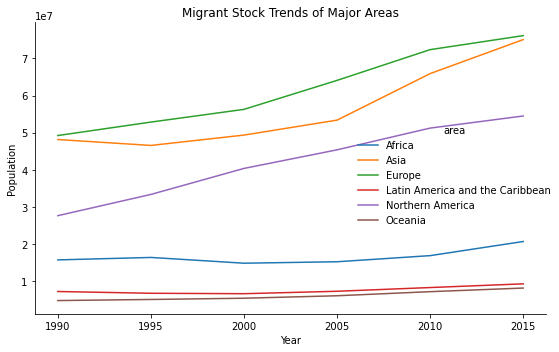

In [42]:
#Table name is
tb_name = 'Table 1'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '2015 all', '1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f']
#Which columns to keep as is for melt
id_vars = ['order',	'area', 'notes', 'country_code', 'type']
#Name of column after melt
value_name = "International migrant stock at mid-year"
value_name_b = f"{value_name} (both sexes)"
value_name_m = f"{value_name} (male)"
value_name_f = f"{value_name} (female)"

#Getting Table 1 ready to process
table = df_tb1 = None
table = prep(table, tb_name, col_name)

#melt & split by sex
table_b = melt_func(table, id_vars, value_vars_b, var_name_year, value_name_b)
table_b = split_year(table_b)

table_m = melt_func(table, id_vars, value_vars_m, var_name_year, value_name_m)
table_m = split_year(table_m)

table_f = melt_func(table, id_vars, value_vars_f, var_name_year, value_name_f)
table_f = split_year(table_f)

#Combine results from male, female, and both sexes
table = table_b[['order', 'area', 'notes', 'country_code', 'type', 'year', value_name_b]].join(table_m[value_name_m]).join(table_f[value_name_f])
#Rename columns in preparation for melt
table.columns = ['order', 'area', 'notes',	'country_code', 'type', 'year', 'both sexes', 'male', 'female']
#melt migrant stock valuse for male and female
#table = table.melt(id_vars = ['order',	'area', 'notes',	'country_code', 'type', 'year'], value_vars = ['both sexes', 'male', 'female'], var_name = 'gender', value_name = value_name)
#Replace empty values with "NaN"
df_tb1 = table.replace(to_replace =['..'],value =['NaN'])

df_tb1_ca = extract_country(df_tb1)
df_tb1_ca = df_tb1_ca.drop(['order', 'notes', 'country_code', "type", 'male', 'female'], axis = 1)
df_tb1_ca.columns = ['area', 'year', 'migrants']
df_tb1_ca

df_tb1_ma = extract_majorarea(df_tb1)
df_tb1_ma_mf = df_tb1_ma.drop(['order', 'notes', 'country_code', "type", 'both sexes'], axis = 1)
df_tb1_ma_all = df_tb1_ma.drop(['order', 'notes', 'country_code', "type", 'male', 'female'], axis = 1)
#df_tb1_ma_mf = df_tb1_ma_mf.melt(id_vars = ['area', 'year'], var_name = "sex", value_name = "count")
df_tb1_ma_mf
df_tb1_ma_all

mig_pop = sns.relplot(data=df_tb1_ma_all, x="year", y='both sexes', hue="area", kind="line")
mig_pop.set(xlabel='Year', ylabel='Population', title='Migrant Stock Trends of Major Areas')
plt.tight_layout()
plt.show()

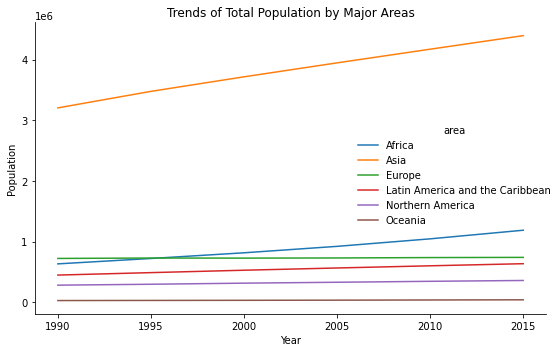

In [43]:
#Defining the variables for functions
#Table name is
tb_name = 'Table 2'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', '1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '2015 all', '1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f']
#Which columns to keep as is for melt
id_vars = ['order',	'area', 'notes', 'country_code']
#Name of column after melt
value_name = "Total population at mid-year (thousands)"
value_name_b = f"{value_name} (both sexes)"
value_name_m = f"{value_name} (male)"
value_name_f = f"{value_name} (female)"

#Getting Table 2 ready to process
table = df_tb2 = None
table = prep(table, tb_name, col_name)

#melt & split by sex
table_b = melt_func(table, id_vars, value_vars_b, var_name_year, value_name_b)
table_b = split_year(table_b)

table_m = melt_func(table, id_vars, value_vars_m, var_name_year, value_name_m)
table_m = split_year(table_m)

table_f = melt_func(table, id_vars, value_vars_f, var_name_year, value_name_f)
table_f = split_year(table_f)

#Combine results from male, female, and both sexes
table = table_b[['order', 'area', 'notes', 'country_code', 'year', value_name_b]].join(table_m[value_name_m]).join(table_f[value_name_f])
#Rename columns in preparation for melt
table.columns = ['order', 'area', 'notes',	'country_code', 'year', 'both sexes', 'male', 'female']
#Replace empty values with "NaN"
df_tb2 = table.replace(to_replace =['..'],value =['NaN'])

df_tb2_ca = extract_country(df_tb2)
df_tb2_ca = df_tb2_ca.drop(['order', 'notes', 'country_code', 'male', 'female'], axis = 1)
df_tb2_ca.columns = ['area', 'year', 'population']
df_tb2_ca

df_tb2_ma = extract_majorarea(df_tb2)
df_tb2_ma = df_tb2_ma.drop(['order', 'notes', 'country_code', 'male', 'female'], axis = 1)


total_pop = sns.relplot(data=df_tb2_ma, x="year", y='both sexes', hue="area", kind="line")
total_pop.set(xlabel='Year', ylabel='Population', title='Trends of Total Population by Major Areas')
plt.tight_layout()
plt.show()

##3.	Migrant Stock Sex Ratio



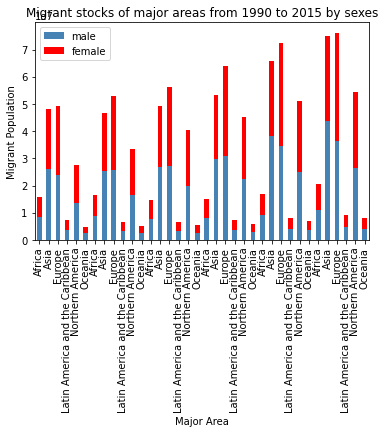

<Figure size 1800x1800 with 0 Axes>

In [44]:
a = df_tb1_ma_mf.set_index('area').plot(kind='bar', stacked=True, color=['steelblue', 'red'], title='Migrant stocks of major areas from 1990 to 2015 by sexes')
a.set_xlabel("Major Area")
a.set_ylabel("Migrant Population")

a = plt.figure(figsize=(15, 15),dpi=120)
plt.show()

<ipython-input-45-94ab23c76fd7>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tb4['is_female'] = df_tb4.apply(lambda row: is_half(row), axis =1)


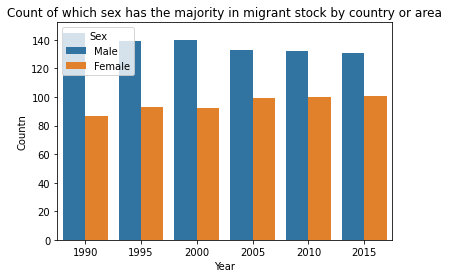

In [45]:
%matplotlib inline  
import plotly.express as px


tb_name = 'Table 4'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f']
#Which columns to keep as is for melt
id_vars = ['order',	'area', 'notes', 'country_code', 'type']
#Name of column after melt
value_name = "Female migrants as a percentage of the international migrant stock"
value_name_f = value_name

#Getting Table 4 ready to process
table = df_tb4 = None
table = prep(table, tb_name, col_name)

#melt & split by sex
table = melt_func(table, id_vars, value_vars_f, var_name_year, value_name_f)
table = split_year(table)

#Rename columns in preparation for melt
table.columns = ['order', 'area', 'notes', 'country_code', 'type', 'Female migrants as a percentage of the international migrant stock', 'year', 'gender']
#Replace empty values with "NaN"
table = table.replace(to_replace =['..'],value =['NaN'])

table = table.replace(to_replace =['f'],value =['female'])
df_tb4 = table[['order', 'area', 'notes', 'country_code', 'type', 'year', 'gender', 'Female migrants as a percentage of the international migrant stock']]

df_tb4
def is_half (row):
    if row["Female migrants as a percentage of the international migrant stock"] > 50:
        return 1
    else:
        return 0


df_tb4['is_female'] = df_tb4.apply(lambda row: is_half(row), axis =1)

df_tb4_ca = extract_country(df_tb4)
df_tb4_ca.columns = ['Order', 'Country and Area', 'Notes',	'Country Code', 'Type', 'Year', 'Gender',	'Female migrants as a percentage of the international migrant stock', 'is_female']
df_tb4_ca

sns.countplot(data = df_tb4_ca, x="Year", hue = "is_female").set(xlabel='Year', ylabel='Countn', title='Count of which sex has the majority in migrant stock by country or area')
plt.legend(title='Sex', loc='upper left', labels=['Male', 'Female'])

plt.show()

##4.	Relationship Between Population and Migrants

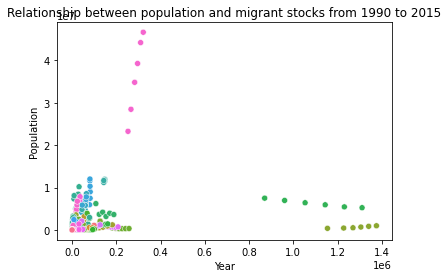

In [46]:
df_popxmigrant = df_tb1_ca.join(df_tb2_ca["population"])
df_popxmigrant

a = sns.scatterplot(x="population", y="migrants", data=df_popxmigrant, hue="area")
a.set(xlabel='Year', ylabel='Population', title='Relationship between population and migrant stocks from 1990 to 2015')
plt.legend([],[], frameon=False)

##5.	Migrant Stock’s Distribution and Impact on Demographic Composition

Text(0.5, 1.0, 'Migrant stock as a percentage of the total population by country or area, 2015')

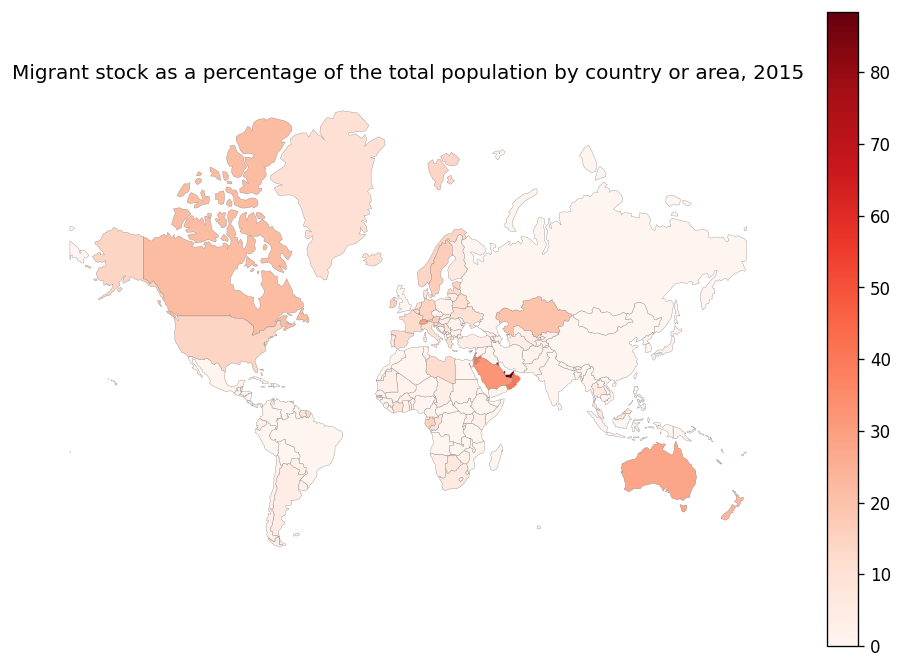

In [47]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != 'Antarctica']
world = world.to_crs("EPSG:3395")

#Defining the variables for functions
#Table name is
tb_name = 'Table 3'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '2015 all', '1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f']

#Getting Table 3 ready to process
table = df_tb3 = None
df_tb3 = prep(table, tb_name, col_name)
df_tb3_ca = extract_country(df_tb3)
df_tb3_ca = df_tb3_ca.drop(['order', 'notes',	'country_code', 'type', '1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f'], axis = 1)

c_a = pd.DataFrame()
c_a["name"] = df_tb3_ca['area']
c_a["number"] = df_tb3_ca['2015 all']

world = pd.merge(world, c_a, on='name', how='left')
world['number'] = world['number'].fillna(0).astype('float')

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
world.plot(ax=ax,
           linewidth=0.2, edgecolor='gray',
           column='number', cmap='Reds',
           legend=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.set_title(
    'Migrant stock as a percentage of the total population by country or area, 2015', size=12)
#p.s. This world map visualization is inspired by: https://zhuyuhao.com/2020/04/05/data-map-1/

Text(0.5, 1.0, 'Migrant stock population by country or area, 2015')

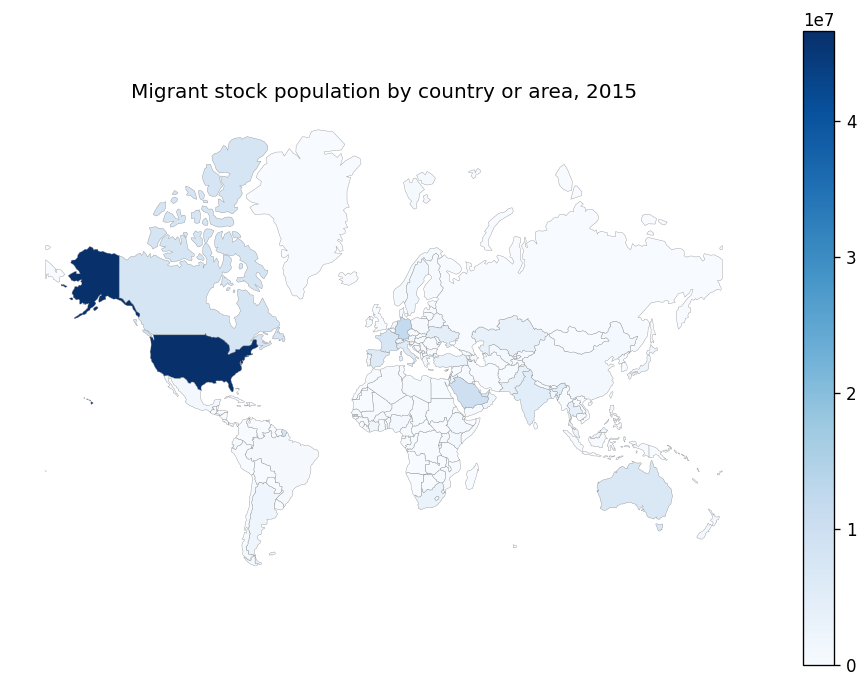

In [48]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != 'Antarctica']
world = world.to_crs("EPSG:3395")

#Defining the variables for functions
#Table name is
tb_name = 'Table 1'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '2015 all', '1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f']

table = df_tb1 = None
df_tb1 = prep(table, tb_name, col_name)
df_tb1_ca = extract_country(df_tb1)
df_tb1_ca = df_tb1_ca.drop(['order', 'notes',	'country_code', 'type', '1990 all', '1995 all', '2000 all', '2005 all', '2010 all', '1990 m', '1995 m', '2000 m', '2005 m', '2010 m', '2015 m', '1990 f', '1995 f', '2000 f', '2005 f', '2010 f', '2015 f'], axis = 1)
df_tb1_ca

c_a_1 = pd.DataFrame()
c_a_1["name"] = df_tb1_ca['area']
c_a_1["number"] = df_tb1_ca['2015 all']

world = pd.merge(world, c_a_1, on='name', how='left')
world['number'] = world['number'].fillna(0).astype('float')

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
world.plot(ax=ax,
           linewidth=0.2, edgecolor='gray',
           column='number', cmap='Blues',
           legend=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.set_title(
    'Migrant stock population by country or area, 2015', size=12)
#p.s. This world map visualization is inspired by: https://zhuyuhao.com/2020/04/05/data-map-1/

Text(0.5, 1.0, 'Rate of change of the migrant stock by country, 2010-2015 (percentage)')

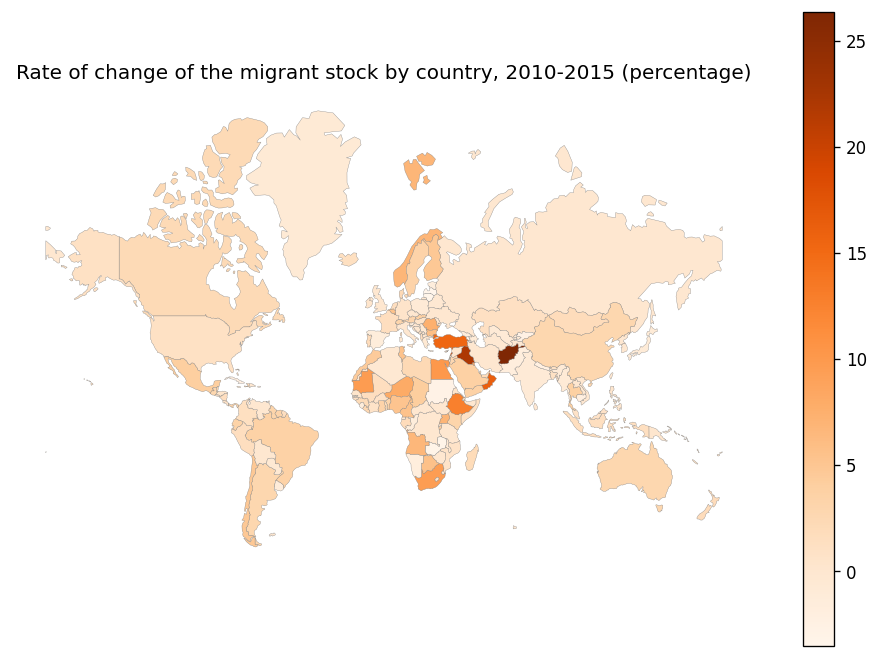

In [49]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != 'Antarctica']
world = world.to_crs("EPSG:3395")


tb_name = 'Table 5'
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990-1995 all', '1995-2000 all', '2000-2005 all', '2005-2010 all', '2010-2015 all', '1990-1995 m', '1995-2000 m', '2000-2005 m', '2005-2010 m', '2010-2015 m', '1990-1995 f', '1995-2000 f', '2000-2005 f', '2005-2010 f', '2010-2015 f']

#Getting Table 5 ready to process
table = df_tb5 = None
df_tb5 = prep(table, tb_name, col_name)


df_tb5_ca = extract_country(df_tb5)
df_tb5_ca = df_tb5_ca.drop(['order', 'notes',	'country_code', 'type', '1990-1995 all', '1995-2000 all', '2000-2005 all', '2005-2010 all', '1990-1995 m', '1995-2000 m', '2000-2005 m', '2005-2010 m', '2010-2015 m', '1990-1995 f', '1995-2000 f', '2000-2005 f', '2005-2010 f', '2010-2015 f'], axis = 1)
df_tb5_ca
c_a = pd.DataFrame()
c_a["name"] = df_tb5_ca['area']
c_a["number"] = df_tb5_ca['2010-2015 all']

world = pd.merge(world, c_a, on='name', how='left')
world['number'] = world['number'].fillna(0).astype('float')

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
world.plot(ax=ax,
           linewidth=0.2, edgecolor='gray',
           column='number', cmap='Oranges',
           legend=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.set_title(
    'Rate of change of the migrant stock by country, 2010-2015 (percentage)', size=12)
#p.s. This world map visualization is inspired by: https://zhuyuhao.com/2020/04/05/data-map-1/

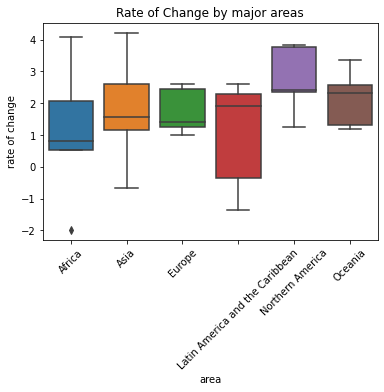

In [50]:
tb_name = 'Table 5'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990-1995 all', '1995-2000 all', '2000-2005 all', '2005-2010 all', '2010-2015 all', '1990-1995 m', '1995-2000 m', '2000-2005 m', '2005-2010 m', '2010-2015 m', '1990-1995 f', '1995-2000 f', '2000-2005 f', '2005-2010 f', '2010-2015 f']
#Which columns to keep as is for melt
id_vars = ['order',	'area', 'notes', 'country_code', 'type']
#Name of column after melt
value_name = "Annual rate of change of the migrant stock"
value_name_b = f"{value_name} (both sexes)"
value_name_m = f"{value_name} (male)"
value_name_f = f"{value_name} (female)"

#Getting Table 5 ready to process
table = df_tb5 = None
table = prep(table, tb_name, col_name)

#melt & split by sex
table_b = melt_func(table, id_vars, value_vars_b_p, var_name_period, value_name_b)
table_b = split_period(table_b)

table_m = melt_func(table, id_vars, value_vars_m_p, var_name_period, value_name_m)
table_m = split_period(table_m)

table_f = melt_func(table, id_vars, value_vars_f_p, var_name_period, value_name_f)
table_f = split_period(table_f)

#Combine results from male, female, and both sexes
table = table_b[['order', 'area', 'notes', 'country_code', 'type', 'period', value_name_b]].join(table_m[value_name_m]).join(table_f[value_name_f])

#Rename columns in preparation for melt
table.columns = ['order', 'area', 'notes',	'country_code', 'type', 'period', 'both sexes', 'male', 'female']
#Dropped the repeated data of Both sexes
table = table.drop(['order', 'notes',	'country_code', 'type', 'male', 'female'], axis = 1)
table.columns = ['area',  'period', 'rate of change']
df_tb5 = table.replace(to_replace =['..'],value =['NaN'])

df_tb5_ma = extract_majorarea(df_tb5)
df_tb5_ma


a = sns.boxplot(data = df_tb5_ma, x='area', y='rate of change')
a.set(title='Rate of Change by major areas')
plt.xticks(rotation=45)
plt.show()

##6.	Global Refugee Stock Distribution

In [51]:
#Defining the variables for functions
#Table name is
tb_name = 'Table 6'
#Names of the columns in the original dataset
col_name = ['order',	'area', 'notes',	'country_code', 'type', '1990', '1995', '2000', '2005', '2010', '2015', '1990 b', '1995 b', '2000 b', '2005 b', '2010 b', '2015 b', '1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015']
#Which columns to keep as is for melt
id_vars = ['order',	'area', 'notes', 'country_code', 'type']
#Name of column after melt
value_name_a = 'Estimated refugee stock at mid-year (both sexes)'
value_name_b = 'Refugees as a percentage of the international migrant stock'
value_name_c = 'Annual rate of change of the refugee stock'

value_vars_a = ['1990', '1995', '2000', '2005', '2010', '2015']
value_vars_b = ['1990 b', '1995 b', '2000 b', '2005 b', '2010 b', '2015 b']
value_vars_c = ['1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015']

var_name_year = 'year'
var_name_period = 'period'


#Getting Table 6 ready to process
table = df_tb6 = None
table = prep(table, tb_name, col_name)

df_tb6_b_ca_2015 = table.drop(['order', 'notes',	'country_code', 'type', '1990', '1995', '2000', '2005', '2010', '2015', '1990 b', '1995 b', '2000 b', '2005 b', '2010 b', '1990-1995', '1995-2000', '2000-2005', '2005-2010', '2010-2015'], axis = 1)
#Processing 3 categories individually
table_a = melt_func(table, id_vars, value_vars_a, var_name_year, value_name_a)
df_tb6_a = table_a.replace(to_replace =['..'],value =['NaN'])
df_tb6_a = df_tb6_a.drop(['order', 'notes', 'country_code', "type"], axis = 1)

table_b = melt_func(table, id_vars, value_vars_b, var_name_year, value_name_b)
table_b = table_b.replace(to_replace =['1990 b', '1995 b', '2000 b', '2005 b', '2010 b', '2015 b'],value =['1990', '1995', '2000', '2005', '2010', '2015'])
df_tb6_b = table_b.replace(to_replace =['..'],value =['NaN'])
df_tb6_b = df_tb6_b.drop(['order', 'notes', 'country_code', "type"], axis = 1)

table_c = melt_func(table, id_vars, value_vars_c, var_name_period, value_name_c)
df_tb6_c = table_c.replace(to_replace =['..'],value =['NaN'])
df_tb6_c = df_tb6_c.drop(['order', 'notes', 'country_code', "type"], axis = 1)

df_tb6_a_ma = extract_majorarea(df_tb6_a)
df_tb6_a_ma.columns = ['area','year', 'refugee count']

#show results
df_tb6_a_ma

,area,year,refugee count
0,Africa,1990,5687352.0
64,Asia,1990,9937007.0
120,Europe,1990,1321884.0
173,Latin America and the Caribbean,1990,1197198.0
225,Northern America,1990,583450.0
231,Oceania,1990,109680.0
259,Africa,1995,5949953.0
323,Asia,1995,7937682.0
379,Europe,1995,2746090.0
432,Latin America and the Caribbean,1995,352256.0


Text(0.5, 1.0, 'Refugees as a percentage of the international migrant stock, 2015')

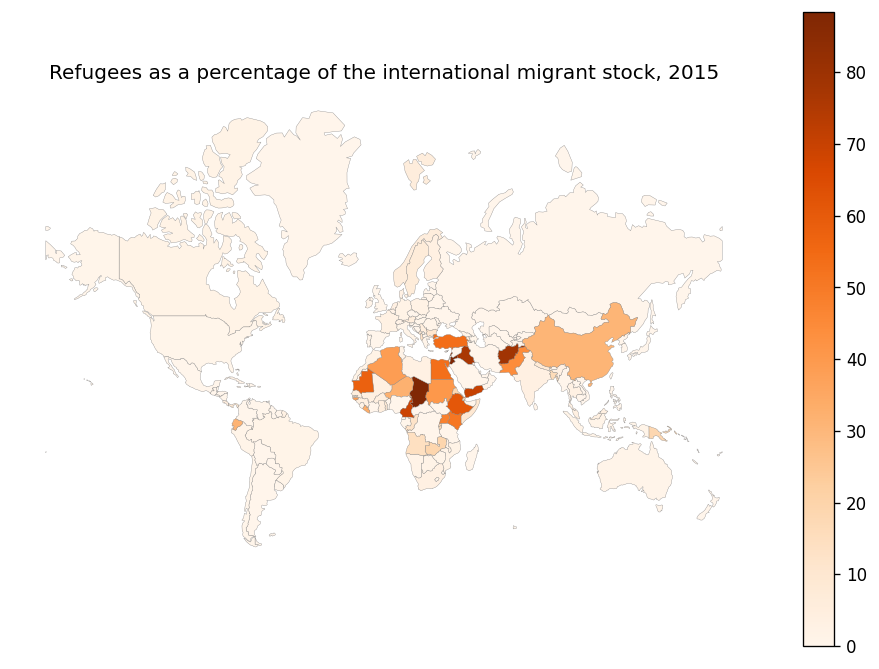

In [52]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.continent != 'Antarctica']
world = world.to_crs("EPSG:3395")

c_a = pd.DataFrame()
c_a["name"] = df_tb6_b_ca_2015['area']
c_a["number"] = df_tb6_b_ca_2015['2015 b']

world = pd.merge(world, c_a, on='name', how='left')
world['number'] = world['number'].fillna(0).astype('float')

fig, ax = plt.subplots(figsize=(10, 7), dpi=120)
world.plot(ax=ax,
           linewidth=0.2, edgecolor='gray',
           column='number', cmap='Oranges',
           legend=True)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.get_xaxis().set_ticks([])
ax.get_yaxis().set_ticks([])

ax.set_title(
    'Refugees as a percentage of the international migrant stock, 2015', size=12)
#p.s. This world map visualization is inspired by: https://zhuyuhao.com/2020/04/05/data-map-1/

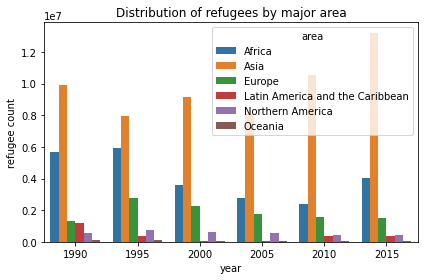

<Figure size 1800x3600 with 0 Axes>

In [53]:
sns.barplot(data = df_tb6_a_ma, y = 'refugee count', x="year", hue = "area").set(title='Distribution of refugees by major area')
plt.tight_layout()
plt.figure(figsize=(15, 30),dpi=120)
plt.show()